In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Py3BR import threebodies, simulate, analysis, plotters
from inputs import input_dict

# Running one trajectory
Initialize the trajectory object by passing the input dictionary to the `TBR` class. Afterwards, use `runT()` to run the trajectory. 

In [3]:
traj = threebodies.TBR(**input_dict)
traj.runT()

# Plotting the trajectory
To plot the trajectory, use the `plotters.traj_plt()` tool. This can be a 2-d or 3-d plot. 

<IPython.core.display.Javascript object>


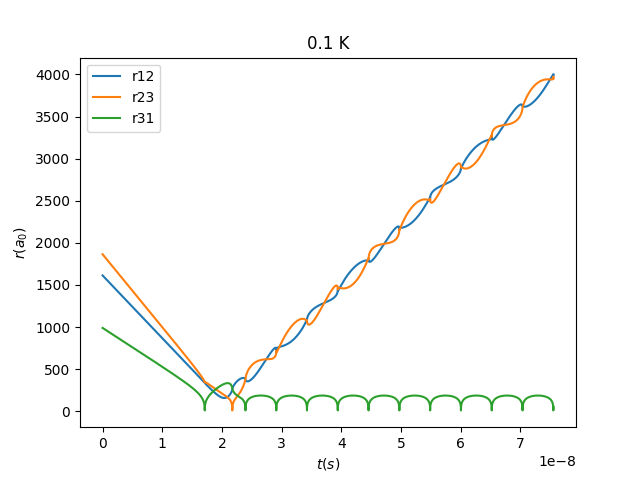

In [4]:
fig, ax = plt.subplots()
plotters.traj_plt(traj, ax)
plt.show()

<IPython.core.display.Javascript object>


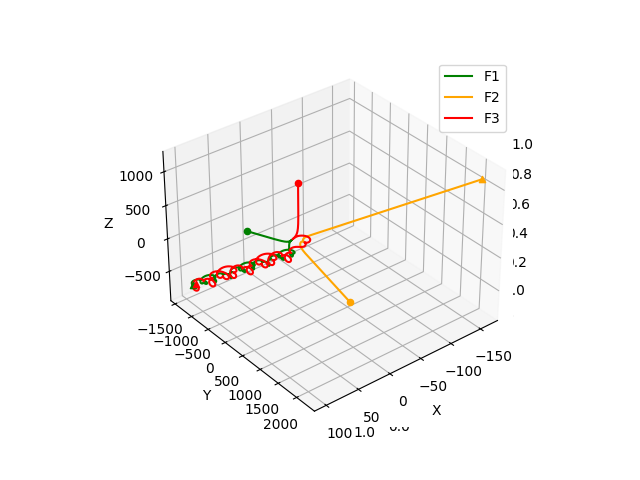

In [11]:
# fig, ax = plt.subplots()
ax = plt.axes(projection='3d')
plotters.traj_3d(traj,ax)
plt.show()

# Sample TBR study of $Sr^+ + Cs + Cs$
To find the opacity function $P(E,b)$, run many trajectories over a range of impact parameters `b` for a given collision energy `E`. The `simulate` module offers parallel or serial computation. The range of `b` should be large enough that $P(E,b)$ reaches close to 0. 

In [6]:
out = 'results/sample.txt' # Output file for analysis
bi = np.arange(0,500,50) # Range of impact parameters
ntraj = 200
results = []
for b in bi:
    input_dict['b0'] = b
    long,short = threebodies.runN(ntraj, input_dict, short_out = out)
    results.append(short)

In [10]:
counts = pd.concat(results)

In [63]:
opac = analysis.opacity(out).reset_index(level=1)
bmax_AB,bmax_BB=analysis.bmax(out,tolerance_AB=1e-3,n_AB=1,tolerance_BB=1e-3,n_BB=1) # Create dictionary of bmax
sigma = analysis.cross_section(out).reset_index(0)
rate = analysis.k3(out,traj.mu0).reset_index(0)

<IPython.core.display.Javascript object>


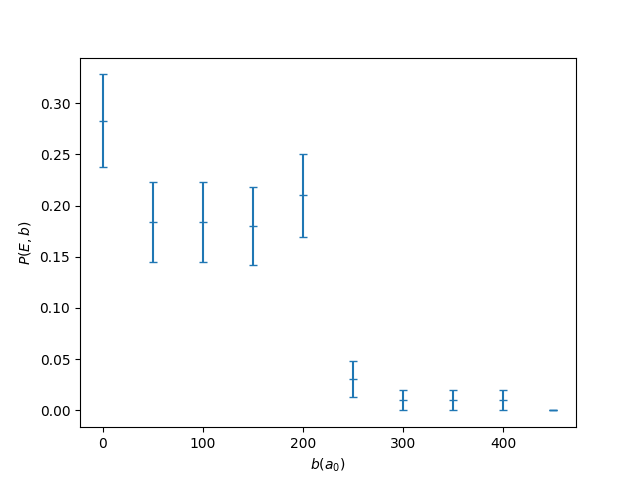

Text(0, 0.5, '$P(E,b)$')

In [65]:
# Plot opacity
plt.figure()
plt.errorbar(opac['b'], opac['pAB'], opac['pAB_err'], capsize = 3,fmt = '_')
plt.xlabel(r'$b (a_0)$')
plt.ylabel(r'$P(E,b)$')

In [66]:
rate

,e,k3_AB,k3_AB_err,k3_BB,k3_BB_err
0,1.0,9.164735e-27,5.594088e-27,0.0,0.0


If you are unsure of $b_{max}$, you can iterate b until $P(E,b)$ reaches a small threshold value.

In [76]:
out = 'results/sample_it.txt'
threshold = 1e-2
input_dict['b0'] = 0  # Reset impact parameter to 0
bint = 50 # Range of impact parameters
ntraj = 200
results = []
while True:
    long,short = threebodies.runN(ntraj, input_dict, short_out = out)
    results.append(short) # Append to results list
    # Calculate opacity
    opac = analysis.opacity(out).reset_index(level=1)
    # Check if opacity < threshold
    if opac[opac['b'] == input_dict['b0']]['pAB'].values[-1] <= threshold:
            break
    input_dict['b0']+=bint # Iterate b 

<IPython.core.display.Javascript object>


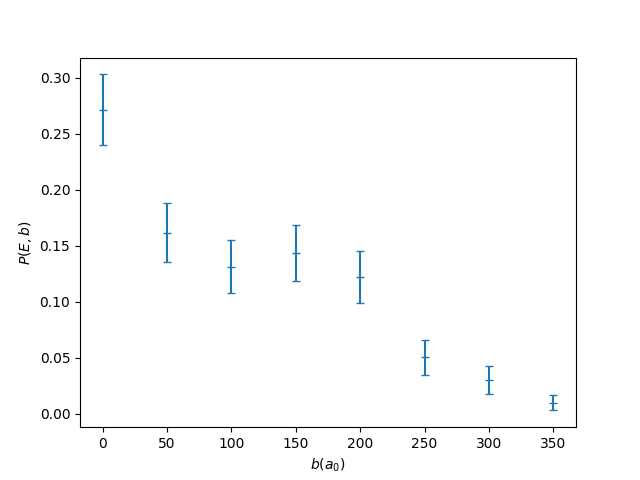

Text(0, 0.5, '$P(E,b)$')

In [77]:
opac = analysis.opacity(out).reset_index(level=1)
# Plot opacity
plt.figure()
plt.errorbar(opac['b'], opac['pAB'], opac['pAB_err'], capsize = 3,fmt = '_')
plt.xlabel(r'$b (a_0)$')
plt.ylabel(r'$P(E,b)$')

# Full Study of $Sr^+ + Cs + Cs$
From the opacity function plot, large errorbars suggest that more trajectories are needed per impact parameter. The large deviations in $P(E,b)$ suggest a more dense grid of impact parameters should be used. For the same energy (E = 1K), we did 3000 trajectories per impact parameter, with an impact parameter spacing of 25. 

In [16]:
analysis.opacity('results/short.txt', mode = 'w',output='results/opacity.txt')

pAB   pAB_err  pBB  pBB_err
e          b                                      
0.0001     0.0    0.272933  0.008655  0.0      0.0
           90.0   0.248671  0.008422  0.0      0.0
           180.0  0.216826  0.008058  0.0      0.0
           270.0  0.183766  0.007508  0.0      0.0
           360.0  0.172195  0.007289  0.0      0.0
...                    ...       ...  ...      ...
65000.0000 69.0   0.000000  0.000000  0.0      0.0
           70.5   0.000000  0.000000  0.0      0.0
           72.0   0.000000  0.000000  0.0      0.0
           73.5   0.000000  0.000000  0.0      0.0
           75.0   0.000000  0.000000  0.0      0.0

[962 rows x 4 columns]

In [17]:
opac_f = pd.read_csv('results/opacity.txt') # Transpose to rows

After running trajectories at different collision energies with appropriate impact parameter ranges, we can create a full three-body recombination rate plot. First, use `analysis.bmax()` to identify b$_{max}$ for each collision energy. Ensure that the suggested b$_{max}$ is large enough that it captures the relevant opacity region. We show this for E = 1 K for the recombination of AB.

In [44]:
# Set tolerance at 1e-3, twice in a row
bmax_AB,bmax_BB = analysis.bmax('results/short.txt',tol_AB=1e-3,n_AB=2,tol_BB=1e-3,n_BB=1)

<IPython.core.display.Javascript object>


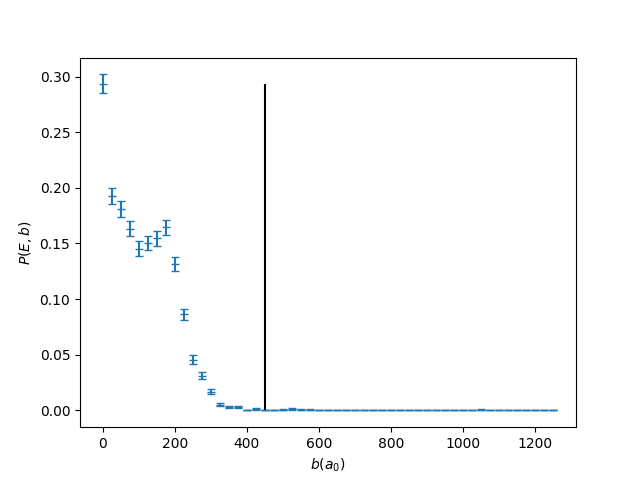

Text(0, 0.5, '$P(E,b)$')

In [45]:
# Look at E = 1K
ec = 1
opac_1 = opac_f[opac_f['e'] == ec].copy()
plt.figure()
plt.errorbar(opac_1['b'], opac_1['pAB'], opac_1['pAB_err'], capsize=3, fmt='_')
plt.vlines(bmax_AB[ec],0,opac_1['pAB'].max(), colors='black')
plt.xlabel(r'$b (a_0)$')
plt.ylabel(r'$P(E,b)$')

If it looks like $b_{max}$ needs to be larger, you can set it manually with `bmax_AB[e] = bval`. For `e=1K`, it looks like we can push it to $b_{max}$ = 600 $a_0$. 

In [46]:
bmax_AB[1] = 600

In [47]:
sigma_f = analysis.cross_section('results/short.txt',bmax_AB,bmax_BB).reset_index()
rate_f = analysis.k3('results/short.txt',traj.mu0,bmax_AB,bmax_BB).reset_index()

In [48]:
rate_f

,e,k3_AB,k3_AB_err,k3_BB,k3_BB_err
0,0.0001,5.078503e-24,4.132404e-25,0.000000e+00,0.000000e+00
1,0.0010,1.146506e-24,1.373402e-25,0.000000e+00,0.000000e+00
2,0.0100,2.009784e-25,2.507305e-26,0.000000e+00,0.000000e+00
3,0.1000,3.811686e-26,5.608029e-27,0.000000e+00,0.000000e+00
4,1.0000,7.445279e-27,1.561343e-27,0.000000e+00,0.000000e+00
5,10.0000,1.561113e-27,3.977720e-28,1.541568e-29,4.236803e-30
6,50.0000,3.197157e-28,3.828719e-29,9.075543e-30,2.759343e-30
7,100.0000,2.033095e-28,2.595039e-29,4.938940e-30,1.248098e-30
8,500.0000,5.479352e-29,8.857998e-30,2.018553e-30,4.682693e-31
9,1000.0000,2.804363e-29,2.958384e-30,1.599649e-30,3.279266e-31


<IPython.core.display.Javascript object>


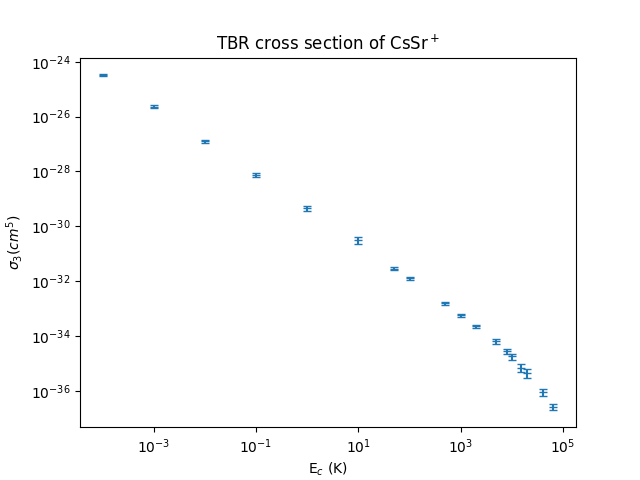

Text(0.5, 1.0, 'TBR cross section of CsSr$^+$')

In [49]:
plt.figure()
plt.errorbar(sigma_f['e'], sigma_f['sig_AB'], sigma_f['sig_AB_err'], capsize=3, fmt='_')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'E$_c$ (K)')
plt.ylabel(r'$\sigma_3 (cm^5)$')
plt.title(r'TBR cross section of CsSr$^+$')

<IPython.core.display.Javascript object>


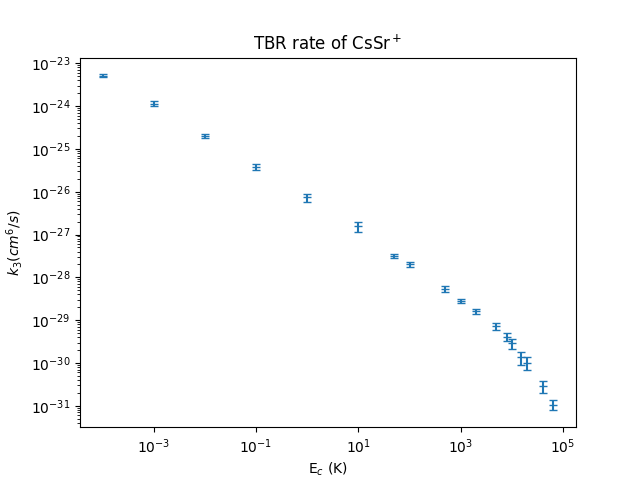

Text(0.5, 1.0, 'TBR rate of CsSr$^+$')

In [50]:
plt.figure()
plt.errorbar(rate_f['e'], rate_f['k3_AB'], rate_f['k3_AB_err'], capsize=3, fmt='_')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'E$_c$ (K)')
plt.ylabel(r'$k_3 (cm^6/s)$')
plt.title(r'TBR rate of CsSr$^+$')